# Gaussian Process for Machine Learning 
## Gaussian sampled prior without known function

- Implementation of "Seeger, M. (2004). Gaussian processes for machine learning. International journal of neural systems, 14(02), 69-106."
- Implementation of Mercer's theorem and the Karhunen-Loeve expansion ([reference](http://www.chebfun.org/examples/stats/MercerKarhunenLoeve.html))
- Equations and approaches are cited from "Bishop, C. M. (2006). Pattern recognition and machine learning. springer."

To apply Gaussian process models to the problem of regression, we need to take account of the noise on the observed target values

$$y_n = u_n + \epsilon_n$$

where $u_n = u(x_n)$ and $\epsilon_n$ is random noise variable whose value is chosen independently for each observation $n$. Assume that we observe $N$ data points in the $N$-dimensional space.

Here we shall consider noise processes that have a Gaussian distribution, so that

$$p(y_n|u_n) = \mathcal{N}(y_n|u_n, \beta^{-1})$$

where $\beta$ is a hyperparameter representing the precision of the noise.

For indenpendent data points, the joint distribution of the target values $\mathbf{y} = (y_1, \dots, y_N)^T$ conditioned on $\mathbf{u} = (u_1, \dots, u_N)^T$ is given by an isotropic Gaussian of the form

$$p(\mathbf{y}|\mathbf{u}) = \mathcal{N}(\mathbf{y}|\mathbf{u}, \beta^{-1}\mathbf{I}_N)$$

where $\mathbf{I}_N$ denotes the N ×N unit matrix. From the definition of a Gaussian process, the marginal distribution $p(\mathbf{u})$ is given by a Gaussian whose mean is zero and whose covariance is defined by a Gram matrix $\mathbf(K)$ so that

$$p(\mathbf{u})=\mathcal{N}(\mathbf{u}|0,\mathbf{K})$$

The kernel function that determines $\mathbf{K}$ is typically chosen to express the property that, for points $x_n$ and $x_m$ that are similar, the corresponding values $u(x_n)$ and $u(x_m)$ will be more strongly correlated than for dissimilar points.

The marginal distribution of $\mathbf{y}$ is given by

$$p(\mathbf{y}) = \int{p(\mathbf{y}|\mathbf{u})p(\mathbf{u})d\mathbf{u}} = \mathcal{N}(\mathbf{y}|0,\mathbf{C})$$

where the covariance matrix $\mathbf{C}$ has elements

$$C(x_n,x_m)=k(x_n,x_m)+\beta^{-1}\delta_{nm}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

One widely used kernel function for Gaussian process regression is given by the exponential of a quadratic form, with the addition of constant and linear terms to give

\begin{align*}
k(x_n,x_m) = \theta_0 \exp{\{ -\frac{\theta_1}{2}\|{x_n-x_m}\|^2 \}} + \theta_2 x_n^T x_m + \theta_3 
\end{align*}


In [2]:
class BaseKernel():
    """
    Kernel from Bishop's Pattern Recognition and Machine Learning pg. 307 Eqn. 6.63.
    """
    def __init__(self,*args):
        self.thetas = args

    def __call__(self,x1,x2):
        exponential = self.thetas[0] * np.exp( -0.5 * self.thetas[1] * np.subtract.outer(x1, x2)**2 )
        linear = self.thetas[2] * np.dot(x1,x2)
        constant = self.thetas[3]
        return exponential + linear + constant 
#        return exponential

The joint distribution over $y_1, \dots, y_{N+1}$ will be given by

$$p(\mathbf{y}_{N+1}) = \mathcal{N}(\mathbf{y}_{N+1}|0,\mathbf{C}_{N+1})$$

Because this joint distribution is Gaussian, we can apply the conditional Gaussian distribution.

$$\mathbf{C}_{N+1} = \left(   
                     \begin{matrix}
                     \mathbf{C}_{N} & \mathbf{k} \\
                     \mathbf{k} & c \\
                     \end{matrix}
                     \right)$$

where $c=k(x_{N+1}, x_{N+1})+\beta^{-1}$. We see that the conditional distribution $p(y_{N+1}|\mathbf{y})$ is a Gaussian distribution with mean and covariance given by 

$$\mu(x_{N+1}) = \mathbf{K}^T \mathbf{C}^{-1}_N \mathbf{y}$$
$$\sigma^2(x_{N+1}) = c-\mathbf{K}^T \mathbf{C}^{-1}_N \mathbf{y}$$

Instead of regressing against some known function, lets just see what happens when we predict based on the sampled prior. 

In [3]:
# Define fundamental functions 
class GP_regressor():
    """
    Implementation of Section 3. Some Gaussian Process Models & Section 9. Choice of Kernel. 
    """
    
    def __init__(self, kernel):
        self.kernel = kernel
        
    # Covariance using given kernel 
    def covariance(self, data):
        return np.reshape([kernel(x1,x2) for x1 in data for x2 in data], (len(data),len(data)))
        
    # Define prior mean and covariance
    def train(self, data):
        mean = np.zeros(len(data))
        C = self.covariance(data)
        return (mean,C)

    # To estimate values
    def estimate(self, mean, C, seed=0):
        ndim = len(mean)
        np.random.seed(seed)
        z = np.random.standard_normal(ndim)
        ## Cholesky is not stable for some parameters
        L = np.linalg.cholesky(C)
        estimation = mean + np.dot(L,z)

        ## Using SVD instead 
        #[U,S,V] = np.linalg.svd(C)
        #A = U * np.sqrt(S)
        #estimation =  mean + np.dot(A,z)
        return estimation
    
    # Conduct prediction
    # The prediction equations are from Bishop pg 308. eqns. 6.66 and 6.67.
    def predict(self, x, data, C, t):
        k = [kernel(x,x2) for x2 in data]
        Cinv = np.linalg.inv(C)
        y_pred = np.dot(np.dot(k,Cinv),t)
        sigma = kernel(x,x) - np.dot(np.dot(k,Cinv),k)
        return (x,y_pred,sigma)            

To estimate unknown ${\bf y}$, we can use the cholesky decompostion (or singular vector decomposition) of $\mathbf{C}$ to find eigenvalues. 
$$\mathbf{C} = \mathbf{L}\mathbf{L}^T$$
$$\mathbf{C} = \mathbf{U}\mathbf{S}\mathbf{V}^*$$


where $L$ is lower triangular with positive diagonal elements. Using $\mathbf{Z} \sim \mathcal{N}(0,1)$, to estimate the value of stochastic process $u$ using Karhunen-Loeve expansion, which is is a representation of a stochastic process as an infinite linear combination of orthogonal functions, analogous to a Fourier series representation of a function on a bounded interval. 
$$u(x, \omega) = \mu(x) + \sum_j^\infty \sqrt{(\lambda_j) \psi_j(x)} Z_j(\omega)$$
where $\lambda_j$ and $\psi_j$ are Mercer eigenmodes for $K$, and the $Z_j$ are uncorrelated and of unit variance.

In [4]:
kernel = BaseKernel(1.0, 10.0, 0.0, 0.0)
gp  = GP_regressor(kernel = kernel)

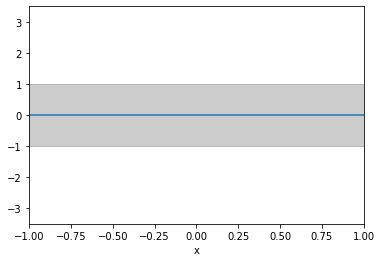

In [5]:
xpts = np.arange(-5, 5, step=0.1)
(m,C) = gp.train(xpts)
sigma_0 = np.diag(C)

plt.figure()
#plt.errorbar(xpts,np.zeros(len(xpts)),yerr=sigma0)
plt.plot(xpts, np.zeros(len(xpts)))
plt.fill_between(xpts, np.zeros(len(xpts))-sigma_0, np.zeros(len(xpts))+sigma_0, alpha=0.2, color='k')
plt.xlabel('x')
plt.xlim(-1.0,1.0)
plt.ylim(-3.5,3.5)
plt.show()

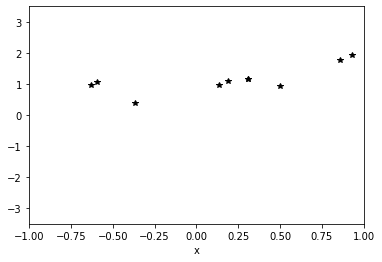

In [6]:
# Some sample training points.
np.random.seed(12345)
xpts = np.random.rand(10) * 2 - 1

# In the context of Gaussian Processes training means simply constructing the kernel matrix.
(m,C) = gp.train(xpts)
ypts = gp.estimate(m,C,0)

plt.figure()
plt.plot(xpts, ypts, "k*")
plt.xlabel('x')
plt.xlim(-1.0,1.0)
plt.ylim(-3.5,3.5)
plt.show()

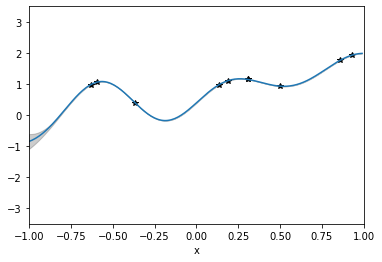

In [7]:
# Explore the results of GP regression in the target domain.
predictions = [gp.predict(i,xpts,C,ypts) for i in np.arange(-1,1,0.01)]

plt.figure()
plt.plot(xpts, ypts, "k*")
x = np.asarray([prediction[0] for prediction in predictions])
y = np.asarray([prediction[1] for prediction in predictions])
sigma = np.asarray([prediction[2] for prediction in predictions])

#plt.errorbar(x,y,yerr=sigma)
plt.plot(x, y)
plt.fill_between(x, y-sigma, y+sigma, alpha=0.2, color='k')
plt.xlabel('x')
plt.xlim(-1.0,1.0)
plt.ylim(-3.5,3.5)
plt.show()

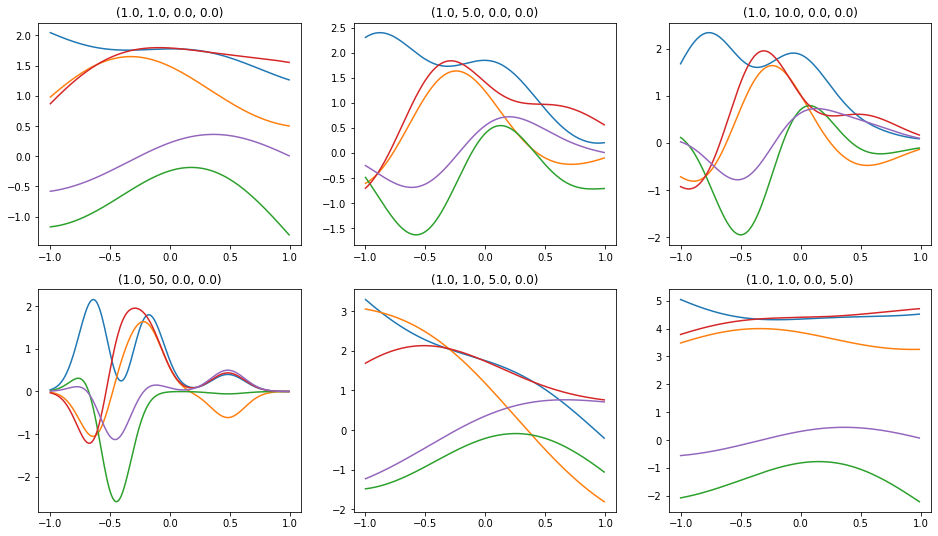

In [8]:
# Random observation with different kernels
kernels = [BaseKernel(1.0, 1.0, 0.0, 0.0), 
           BaseKernel(1.0, 5.0, 0.0, 0.0), 
           BaseKernel(1.0, 10.0, 0.0, 0.0),
           BaseKernel(1.0, 50, 0.0, 0.0),
           BaseKernel(1.0, 1.0, 5.0, 0.0),
           BaseKernel(1.0, 1.0, 0.0, 5.0)]

fig = plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
k = 0

for kernel in kernels:
    k = k+1
    # print(kernel.thetas)
    gp  = GP_regressor(kernel = kernel)

    # Uniform points.
    np.random.seed(12345)
    xpts = np.random.normal(0,1,5)

    # In the context of Gaussian Processes training means simply constructing the kernel matrix.
    (m,C) = gp.train(xpts)

    ax = fig.add_subplot(2,3,k)
    for j in range(0,5):
        ypts = gp.estimate(m,C,j)
        # Explore the results of GP regression in the target domain.
        predictions = [gp.predict(i,xpts,C,ypts) for i in np.arange(-1,1,0.01)]

        # Plot figures
        x = np.asarray([prediction[0] for prediction in predictions])
        y = np.asarray([prediction[1] for prediction in predictions])
        sigma = np.asarray([prediction[2] for prediction in predictions])
        
        ax.plot(x,y)
        ax.set_title('%s' %str(kernel.thetas))

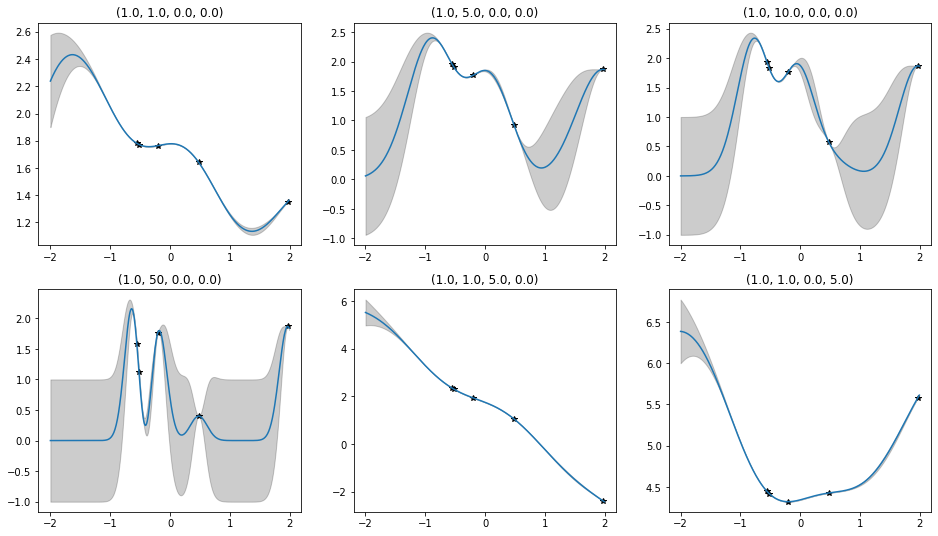

In [9]:
# Approximation with different kernels
kernels = [BaseKernel(1.0, 1.0, 0.0, 0.0), 
           BaseKernel(1.0, 5.0, 0.0, 0.0), 
           BaseKernel(1.0, 10.0, 0.0, 0.0),
           BaseKernel(1.0, 50, 0.0, 0.0),
           BaseKernel(1.0, 1.0, 5.0, 0.0),
           BaseKernel(1.0, 1.0, 0.0, 5.0)]

fig = plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
k = 0

for kernel in kernels:
    k = k+1
    # print("Kernel weights:", kernel.thetas)
    gp  = GP_regressor(kernel = kernel)
    
    # Some sample training points.
    np.random.seed(12345)
    xpts = np.random.normal(0,1,5)
    #xpts = np.random.rand(5) * 2 - 1

    # In the context of Gaussian Processes training means simply constructing the kernel matrix.
    (m,C) = gp.train(xpts)
    ypts = gp.estimate(m,C)
    
    # Explore the results of GP regression in the target domain.
    predictions = [gp.predict(i,xpts,C,ypts) for i in np.arange(-2,2,0.01)]

    # Plot figures
    x = np.asarray([prediction[0] for prediction in predictions])
    y = np.asarray([prediction[1] for prediction in predictions])
    sigma = np.asarray([prediction[2] for prediction in predictions])

    ax = fig.add_subplot(2,3,k)    
    ax.plot(xpts, ypts, "k*")
    ax.plot(x, y)
    ax.fill_between(x, y-sigma, y+sigma, alpha=0.2, color='k')    
    ax.set_title('%s' %str(kernel.thetas))

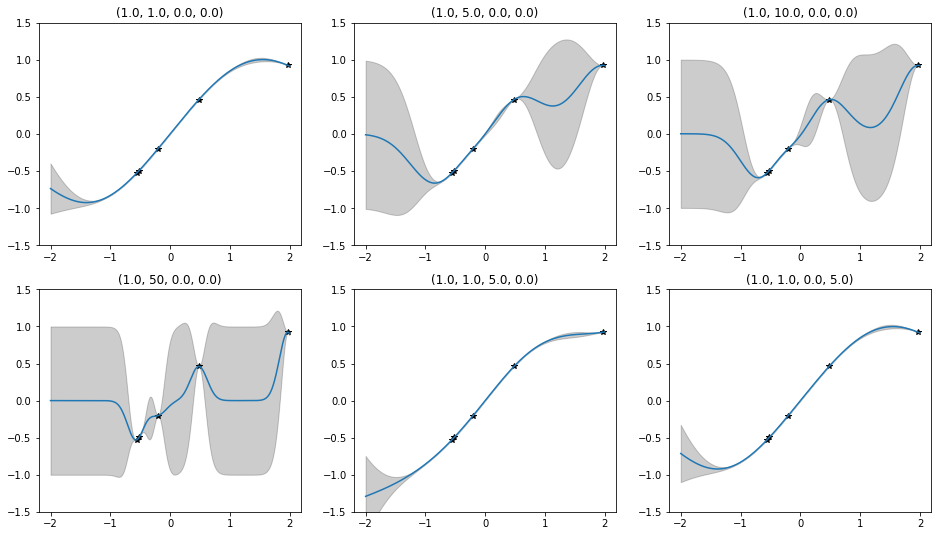

In [10]:
# Given data with different kernels 
kernels = [BaseKernel(1.0, 1.0, 0.0, 0.0), 
           BaseKernel(1.0, 5.0, 0.0, 0.0), 
           BaseKernel(1.0, 10.0, 0.0, 0.0),
           BaseKernel(1.0, 50, 0.0, 0.0),
           BaseKernel(1.0, 1.0, 5.0, 0.0),
           BaseKernel(1.0, 1.0, 0.0, 5.0)]

fig = plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')
k = 0

for kernel in kernels:
    k = k+1
    # print("Kernel weights:", kernel.thetas)
    gp  = GP_regressor(kernel = kernel)
    
    # Some sample training points.
    np.random.seed(12345)
    xpts = np.random.normal(0,1,5)
    #xpts = np.random.rand(5) * 2 - 1

    # In the context of Gaussian Processes training means simply constructing the kernel matrix.
    (m,C) = gp.train(xpts)
    ypts = np.sin(xpts)
    
    # Explore the results of GP regression in the target domain.
    predictions = [gp.predict(i,xpts,C,ypts) for i in np.arange(-2,2,0.01)]

    # Plot figures
    x = np.asarray([prediction[0] for prediction in predictions])
    y = np.asarray([prediction[1] for prediction in predictions])
    sigma = np.asarray([prediction[2] for prediction in predictions])

    ax = fig.add_subplot(2,3,k)    
    ax.plot(xpts, ypts, "k*")
    ax.plot(x, y)
    ax.set_ylim([-1.5, 1.5])
    ax.fill_between(x, y-sigma, y+sigma, alpha=0.2, color='k')    
    ax.set_title('%s' %str(kernel.thetas))

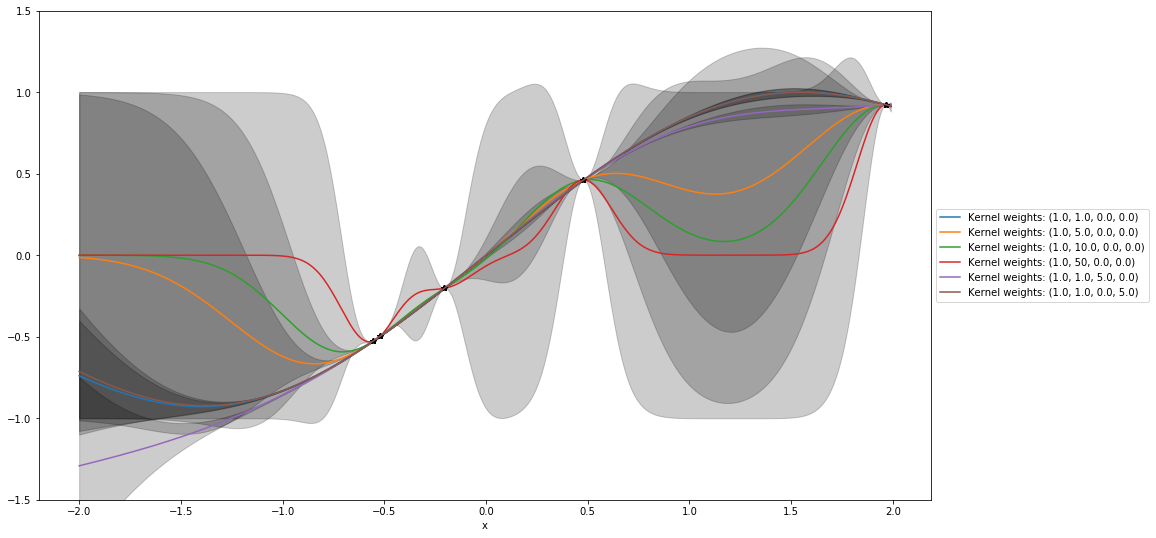

In [11]:
# Given data with different kernels 
kernels = [BaseKernel(1.0, 1.0, 0.0, 0.0), 
           BaseKernel(1.0, 5.0, 0.0, 0.0), 
           BaseKernel(1.0, 10.0, 0.0, 0.0),
           BaseKernel(1.0, 50, 0.0, 0.0),
           BaseKernel(1.0, 1.0, 5.0, 0.0),
           BaseKernel(1.0, 1.0, 0.0, 5.0)]

fig = plt.figure(figsize=(16,9), facecolor='w', edgecolor='k')

for kernel in kernels:
#    print("Kernel weights:", kernel.thetas)
    gp  = GP_regressor(kernel = kernel)
    
    # Some sample training points.
    np.random.seed(12345)
    xpts = np.random.normal(0,1,5)
    #xpts = np.random.rand(5) * 2 - 1

    # In the context of Gaussian Processes training means simply constructing the kernel matrix.
    (m,C) = gp.train(xpts)
    ypts = np.sin(xpts)
    
    # Explore the results of GP regression in the target domain.
    predictions = [gp.predict(i,xpts,C,ypts) for i in np.arange(-2,2,0.01)]

    # Plot figures
    x = np.asarray([prediction[0] for prediction in predictions])
    y = np.asarray([prediction[1] for prediction in predictions])
    sigma = np.asarray([prediction[2] for prediction in predictions])

    plt.plot(xpts, ypts, "k*")
    #    plt.errorbar(x,y,yerr=sigma)
    plt.plot(x, y, label='Kernel weights: %s' %str(kernel.thetas))
    plt.fill_between(x, y-sigma, y+sigma, alpha=0.2, color='k')    
    plt.xlabel('x')
    plt.ylim(-1.5,1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()    

### references
- Bishop's Pattern Recognition and Machine Learning: http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf
- Basic code: https://gist.github.com/stober/4964727
- https://peterroelants.github.io/posts/gaussian-process-kernels/
- https://katbailey.github.io/post/gaussian-processes-for-dummies/